In [13]:
import pandas as pd
import re
import nltk

# Load the dataset
df = pd.read_csv('/content/apps.csv')

# Display the first few rows of the dataset
print(df.head())

# Drop rows with missing reviews
df.dropna(subset=['Reviews'], inplace=True)

# Define a function to clean text
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Clean the 'Reviews' column
df['cleaned_reviews'] = df['Reviews'].apply(clean_text)

# Display the cleaned reviews
print(df[['Reviews', 'cleaned_reviews']].head())


   Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating  Reviews  Size     Installs  Type Price  \
0  ART_AND_DESIGN     4.1      159   19M      10,000+  Free     0   
1  ART_AND_DESIGN     3.9      967   14M     500,000+  Free     0   
2  ART_AND_DESIGN     4.7    87510  8.7M   5,000,000+  Free     0   
3  ART_AND_DESIGN     4.5   215644   25M  50,000,000+  Free     0   
4  ART_AND_DESIGN     4.3      967  2.8M     100,000+  Free     0   

  Content Rating                     Genres      Last Updated  \
0       Everyone               Art & Design   January 7, 2018   
1       Everyone  Art & Design;Pretend Play  J

In [22]:
# Function to label sentiments based on ratings
def sentiment_label(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to create a new sentiment column
df['sentiment'] = df['Rating'].round(1).apply(sentiment_label)

# Display sentiment labels
print(df[['Rating', 'sentiment']].head())


   Rating sentiment
0     4.1  positive
1     3.9  negative
2     4.7  positive
3     4.5  positive
4     4.3  positive


In [23]:
import numpy as np
import gensim.downloader as api
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load the GloVe embeddings (use a smaller model to avoid long download times)
glove_model = api.load("glove-wiki-gigaword-50")  # 50-dimensional embeddings

# Function to get the vector for a given review
def get_review_vector(review):
    words = review.split()
    # Only calculate the mean if there are words in the review that exist in GloVe
    valid_words = [glove_model[word] for word in words if word in glove_model]
    if len(valid_words) > 0:
        return np.mean(valid_words, axis=0)
    else:
        return np.zeros(50)  # Return a zero vector if no valid words are found

# Apply to the cleaned reviews
X = np.array([get_review_vector(review) for review in df['cleaned_reviews']])

# Get the labels (target variable)
y = df['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)

# Train the model
log_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.64
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       684
     neutral       0.00      0.00      0.00        14
    positive       0.64      1.00      0.78      1234

    accuracy                           0.64      1932
   macro avg       0.21      0.33      0.26      1932
weighted avg       0.41      0.64      0.50      1932



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


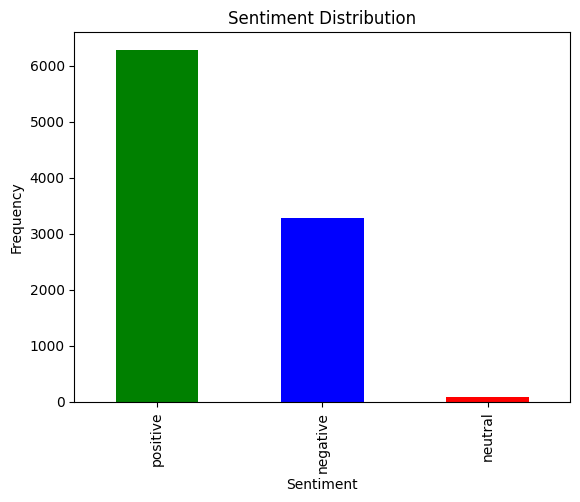

In [24]:
import matplotlib.pyplot as plt

# Plot the distribution of sentiments
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()
